In [1]:
import pandas as pd
from sklearn.metrics import mean_absolute_error

from scripts.forecast_plot import forecast_plot

from prophet import Prophet
from prophet.plot import (
    plot_plotly,
    plot_components_plotly,
    add_changepoints_to_plot,
    plot_forecast_component,
)

In [2]:
data = pd.read_csv('data/Air_passengers/AirPassengers.csv')
print(data.shape)
data.head()

(144, 2)


,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
# # specifying carrying capacity 
# data['cap'] = 200

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [5]:
#convert Month column to datetime
data['Month'] = pd.to_datetime(data['Month'])
data.head()

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [6]:
data['#Passengers'].max()

622

In [7]:
import plotly.express as px

fig = px.line(data, x='Month', y='#Passengers', title='Air Passengers')
fig.show() 

## Time Series Forecasting with Prophet 

In [8]:
data.rename(columns={'Month': 'ds', '#Passengers': 'y'}, inplace=True)

data.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [9]:
data['ds'].dt.year.unique()

array([1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959,
       1960], dtype=int32)

In [10]:
valid_data = data[data['ds'].dt.year.isin([1959, 1960])]
train_data = data[~(data['ds'].dt.year.isin([1959, 1960]))]

print(f'Train data shape: {train_data.shape}')
print(f'Validation data shape: {valid_data.shape}')

Train data shape: (120, 2)
Validation data shape: (24, 2)


In [11]:
model = Prophet()
model.add_country_holidays(country_name='US')   
model.fit(train_data)

00:36:38 - cmdstanpy - INFO - Chain [1] start processing
00:36:38 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
forecast = model.predict(valid_data)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
19,1960-08-01,522.406441,499.371035,546.717164
20,1960-09-01,485.162684,460.738022,508.818506
21,1960-10-01,450.437346,426.227913,474.774175
22,1960-11-01,422.286830,397.568041,446.440819
23,1960-12-01,448.586507,424.086315,471.321523


In [13]:
forecast.shape

(24, 64)

In [14]:
model.train_holiday_names

0                  New Year's Day
1           Washington's Birthday
2                    Memorial Day
3                Independence Day
4                       Labor Day
5                    Columbus Day
6                   Armistice Day
7                    Thanksgiving
8                   Christmas Day
9     Independence Day (Observed)
10      New Year's Day (Observed)
11                   Veterans Day
12       Christmas Day (Observed)
13        Veterans Day (Observed)
14       Armistice Day (Observed)
dtype: object

In [15]:
mean_absolute_error(valid_data['y'], forecast['yhat'])

30.995675815316186

In [16]:
plot_plotly(model, forecast)

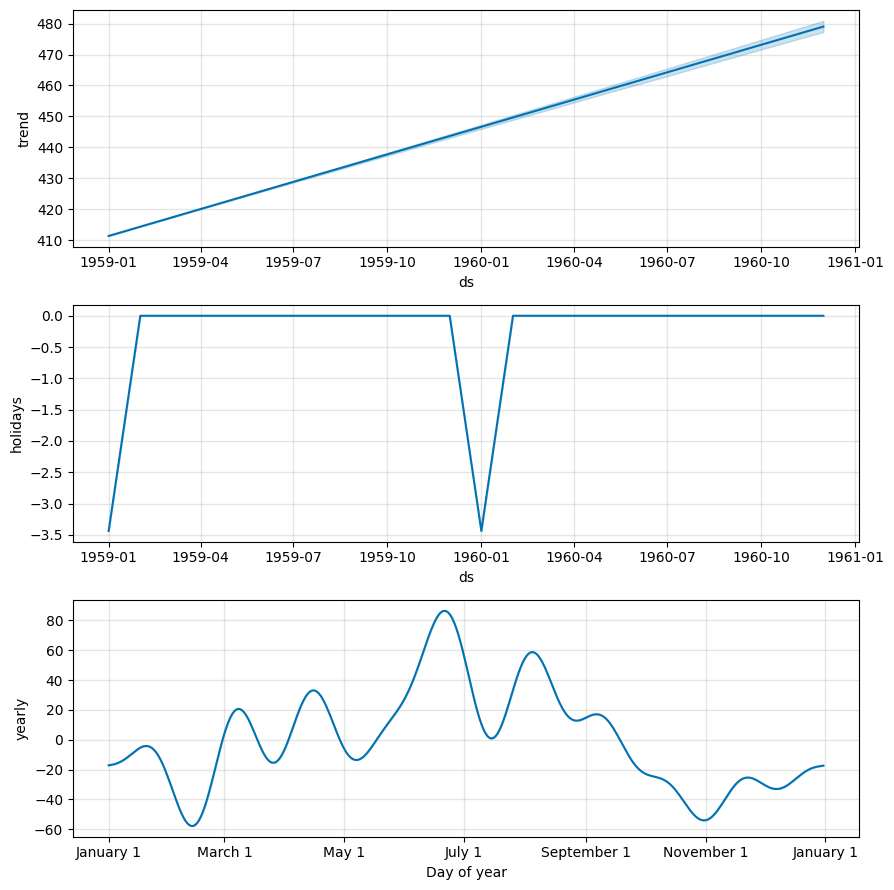

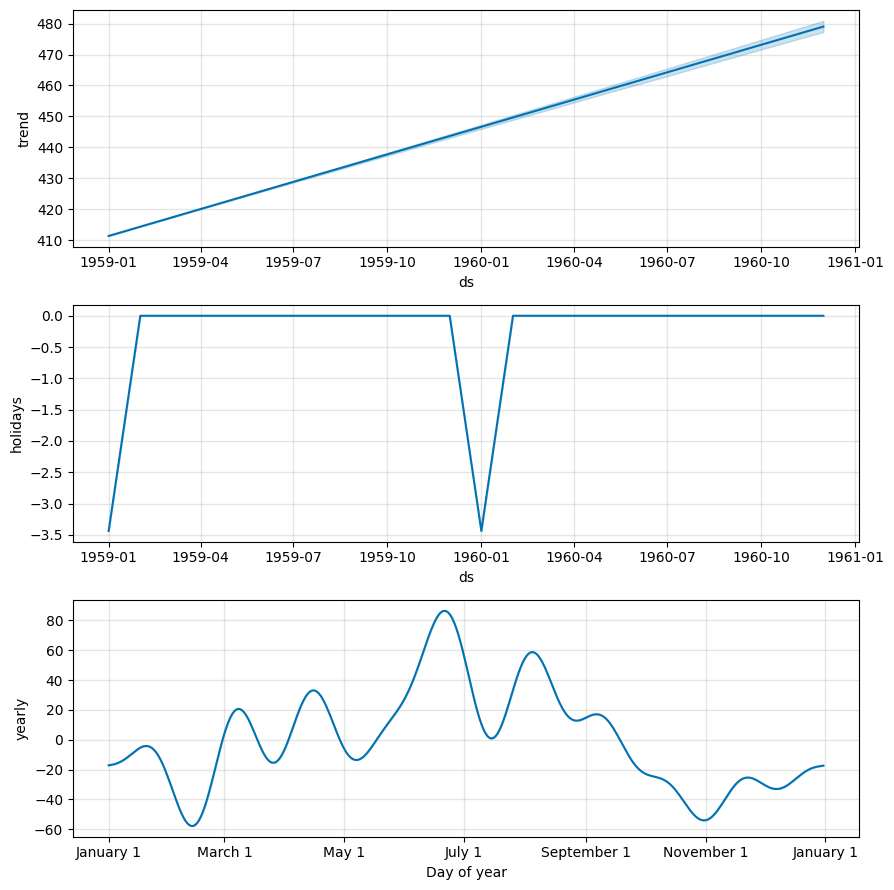

In [17]:
model.plot_components(forecast)

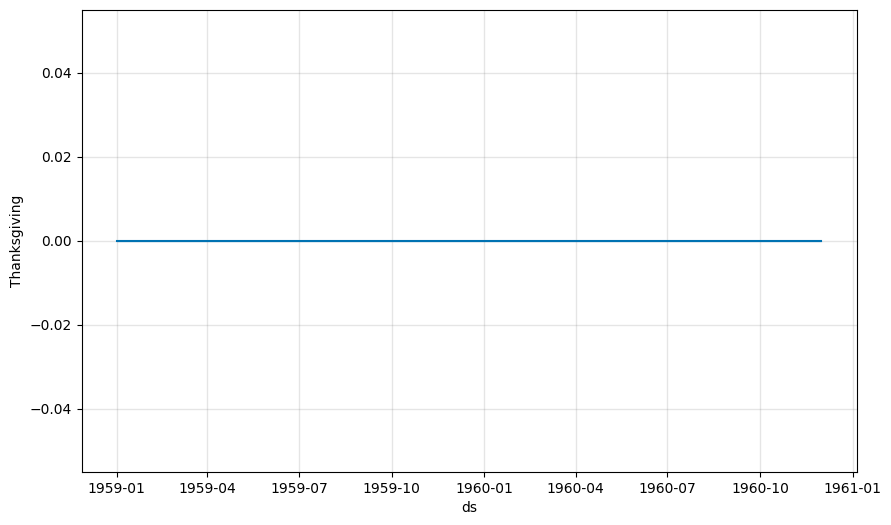

In [18]:
fig = plot_forecast_component(model, forecast, 'Thanksgiving')

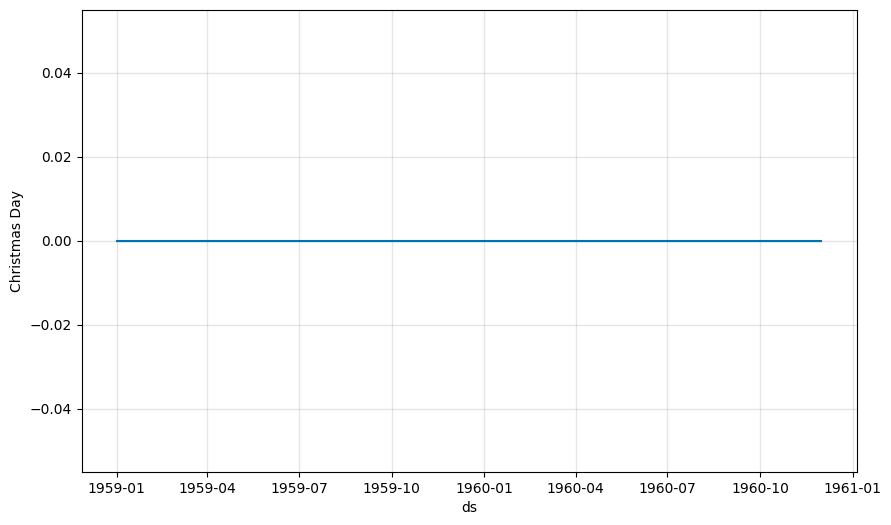

In [19]:
fig = plot_forecast_component(model, forecast, 'Christmas Day')

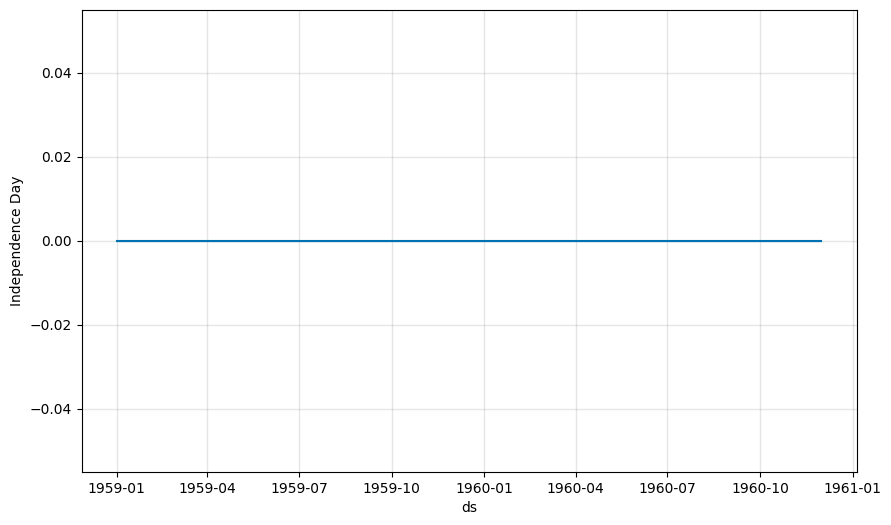

In [20]:
fig = plot_forecast_component(model, forecast, 'Independence Day')

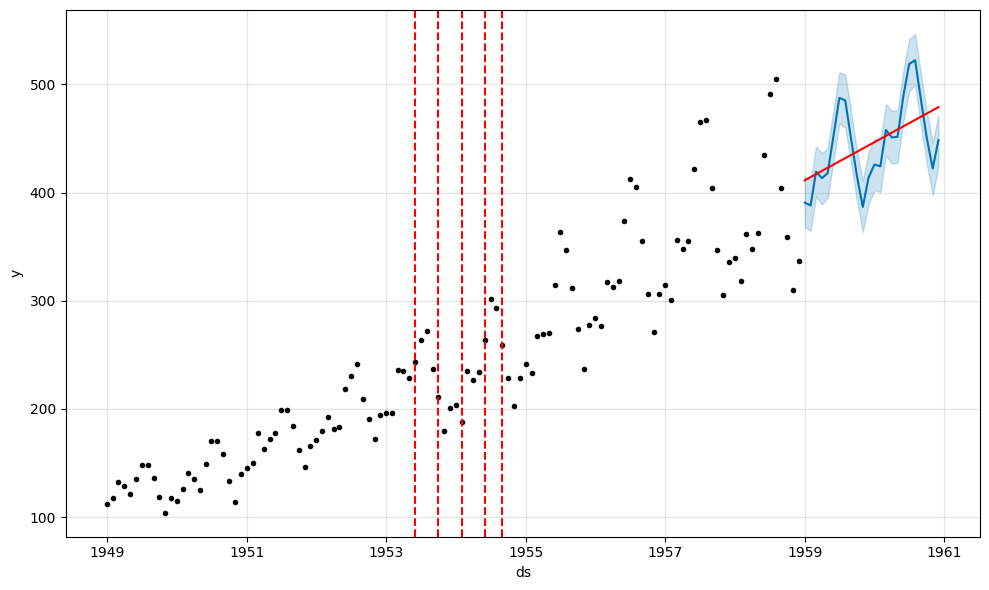

In [21]:
# Change point detection
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

In [22]:
# model.changepoints

In [23]:
forecast_plot(
    train_data,
    valid_data,
    'ds',
    forecast["yhat"],
    ["Train", "Valid", "Predict"],
    "Prophet",
    "Date",
    "Demand",
)

### Cross Validation

$$ N = 1 + \lfloor \frac{T - I}{P} \rfloor  $$
$$ NP = 1 + (N-1)   $$

where 
- $N$ - number of periods
- $NP$ - number of forecasts
- $T$ - total time
- $I$ - initial
- $P$ - prediction interval (period)

In [24]:
from prophet.diagnostics import cross_validation

df_cv = cross_validation(
    model, initial="730 days", period="180 days", horizon="365 days"
)


  0%|          | 0/15 [00:00<?, ?it/s]

00:36:46 - cmdstanpy - INFO - Chain [1] start processing
00:37:00 - cmdstanpy - INFO - Chain [1] done processing
00:37:00 - cmdstanpy - INFO - Chain [1] start processing
00:37:00 - cmdstanpy - INFO - Chain [1] done processing
00:37:01 - cmdstanpy - INFO - Chain [1] start processing
00:37:01 - cmdstanpy - INFO - Chain [1] done processing
00:37:01 - cmdstanpy - INFO - Chain [1] start processing
00:37:02 - cmdstanpy - INFO - Chain [1] done processing
00:37:02 - cmdstanpy - INFO - Chain [1] start processing
00:37:02 - cmdstanpy - INFO - Chain [1] done processing
00:37:03 - cmdstanpy - INFO - Chain [1] start processing
00:37:03 - cmdstanpy - INFO - Chain [1] done processing
00:37:03 - cmdstanpy - INFO - Chain [1] start processing
00:37:04 - cmdstanpy - INFO - Chain [1] done processing
00:37:04 - cmdstanpy - INFO - Chain [1] start processing
00:37:04 - cmdstanpy - INFO - Chain [1] done processing
00:37:05 - cmdstanpy - INFO - Chain [1] start processing
00:37:05 - cmdstanpy - INFO - Chain [1]

In [25]:
df_cv.head()


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1951-02-01,158.145279,158.010473,158.277460,150,1951-01-07
1,1951-03-01,169.995016,169.563142,170.420115,178,1951-01-07
2,1951-04-01,156.896897,156.010846,157.725916,163,1951-01-07
3,1951-05-01,141.702767,140.289095,143.062707,172,1951-01-07
4,1951-06-01,174.026826,172.046636,175.856076,178,1951-01-07


In [26]:
df_cv.shape

(180, 6)

In [27]:
df_cv.groupby('cutoff').count()

,ds,yhat,yhat_lower,yhat_upper,y
cutoff,,,,,
1951-01-07,12,12,12,12,12
1951-07-06,12,12,12,12,12
1952-01-02,12,12,12,12,12
1952-06-30,12,12,12,12,12
1952-12-27,12,12,12,12,12
1953-06-25,12,12,12,12,12
1953-12-22,12,12,12,12,12
1954-06-20,12,12,12,12,12
1954-12-17,12,12,12,12,12


In [28]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,812.834316,28.510249,20.944857,0.068909,0.059894,0.070451,0.166667
1,41 days,922.657518,30.375278,23.013931,0.080342,0.072543,0.080419,0.166667
2,42 days,962.691613,31.027272,24.153982,0.083548,0.083682,0.083926,0.166667
3,46 days,964.549067,31.057190,24.272543,0.084246,0.083682,0.084566,0.222222
4,47 days,1053.877795,32.463484,25.559439,0.085359,0.083682,0.086547,0.222222


In [29]:
df_p['mae'].values[0]

20.94485745175749

In [30]:
df_p.shape

(147, 8)

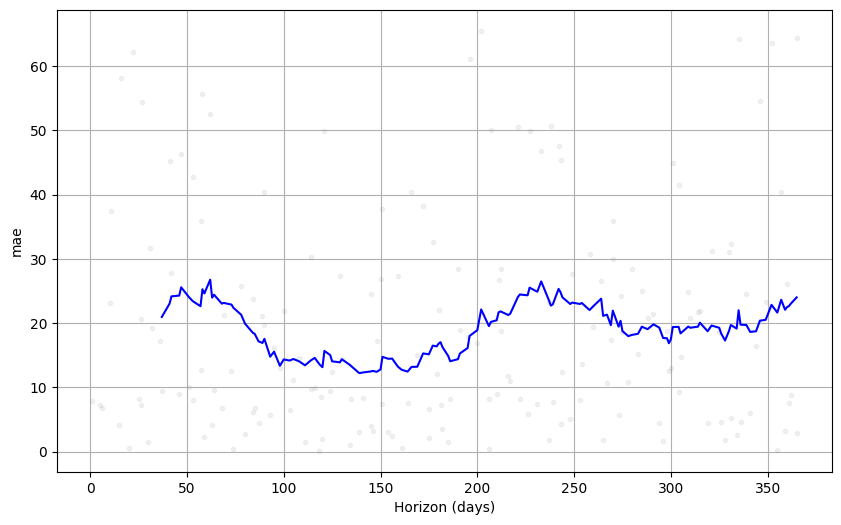

In [31]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mae')


### Hyper Parameter Tuning

In [32]:
from itertools import product

In [33]:
help(product)

Help on class product in module itertools:

class product(builtins.object)
 |  product(*iterables, repeat=1) --> product object
 |  
 |  Cartesian product of input iterables.  Equivalent to nested for-loops.
 |  
 |  For example, product(A, B) returns the same as:  ((x,y) for x in A for y in B).
 |  The leftmost iterators are in the outermost for-loop, so the output tuples
 |  cycle in a manner similar to an odometer (with the rightmost element changing
 |  on every iteration).
 |  
 |  To compute the product of an iterable with itself, specify the number
 |  of repetitions with the optional repeat keyword argument. For example,
 |  product(A, repeat=4) means the same as product(A, A, A, A).
 |  
 |  product('ab', range(3)) --> ('a',0) ('a',1) ('a',2) ('b',0) ('b',1) ('b',2)
 |  product((0,1), (0,1), (0,1)) --> (0,0,0) (0,0,1) (0,1,0) (0,1,1) (1,0,0) ...
 |  
 |  Methods defined here:
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __iter__(self, /

In [34]:
list(product([0,1], [1,2]))

[(0, 1), (0, 2), (1, 1), (1, 2)]

In [35]:
dict(zip([1,2], [3,4]))

{1: 3, 2: 4}

In [36]:
param_grid = {
    "changepoint_prior_scale": [0.001, 0.01, 0.1, 0.5],
    "seasonality_prior_scale": [0.01, 0.1, 1.0, 10.0],
    # "seasonality_mode": ['additive', 'multiplicative']
}

# print(param_grid.values())
# print(*param_grid.values())

# { 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01}

print(list(product(*param_grid.values())))

all_params = [
    dict(zip(param_grid.keys(), value)) for value in product(*param_grid.values())
]

# for value in product(*param_grid.values()):
#     all_params.append(dict(zip(param_grid.keys(), value)))

# all_params


[(0.001, 0.01), (0.001, 0.1), (0.001, 1.0), (0.001, 10.0), (0.01, 0.01), (0.01, 0.1), (0.01, 1.0), (0.01, 10.0), (0.1, 0.01), (0.1, 0.1), (0.1, 1.0), (0.1, 10.0), (0.5, 0.01), (0.5, 0.1), (0.5, 1.0), (0.5, 10.0)]


In [37]:
train_data.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [38]:
mae_list = []

for params in all_params:
    model = Prophet(**params).fit(train_data)
    df_cv = cross_validation(model, horizon="150 days", parallel="processes")
    df_p = performance_metrics(df_cv)
    mae_list.append(df_p['mae'].values[0])

00:37:14 - cmdstanpy - INFO - Chain [1] start processing
00:37:14 - cmdstanpy - INFO - Chain [1] done processing
00:37:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
00:37:14 - cmdstanpy - INFO - Chain [1] start processing


00:37:14 - cmdstanpy - INFO - Chain [1] done processing
00:37:14 - cmdstanpy - INFO - Chain [1] start processing
00:37:14 - cmdstanpy - INFO - Chain [1] start processing
00:37:14 - cmdstanpy - INFO - Chain [1] start processing
00:37:14 - cmdstanpy - INFO - Chain [1] start processing
00:37:14 - cmdstanpy - INFO - Chain [1] start processing
00:37:14 - cmdstanpy - INFO - Chain [1] start processing
00:37:14 - cmdstanpy - INFO - Chain [1] start processing
00:37:14 - cmdstanpy - INFO - Chain [1] start processing
00:37:14 - cmdstanpy - INFO - Chain [1] start processing
00:37:15 - cmdstanpy - INFO - Chain [1] start processing
00:37:15 - cmdstanpy - INFO - Chain [1] done processing
00:37:15 - cmdstanpy - INFO - Chain [1] start processing
00:37:15 - cmdstanpy - INFO - Chain [1] start processing
00:37:15 - cmdstanpy - INFO - Chain [1] done processing
00:37:15 - cmdstanpy - INFO - Chain [1] done processing
00:37:15 - cmdstanpy - INFO - Chain [1] done processing
00:37:15 - cmdstanpy - INFO - Chain 

In [39]:
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = mae_list
tuning_results.head()

,changepoint_prior_scale,seasonality_prior_scale,mae
0,0.001,0.01,17.858652
1,0.001,0.10,15.120136
2,0.001,1.00,16.712508
3,0.001,10.00,21.403408
4,0.010,0.01,18.273276


In [44]:
tuning_results[tuning_results["mae"] == tuning_results["mae"].min()]



,changepoint_prior_scale,seasonality_prior_scale,mae
13,0.5,0.1,14.955821


In [45]:
import numpy as np

best_params = all_params[np.argmin(mae_list)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1}


In [46]:
new_model = Prophet(**best_params)
new_model.fit(train_data)
new_forecast = model.predict(valid_data)

00:46:53 - cmdstanpy - INFO - Chain [1] start processing
00:46:53 - cmdstanpy - INFO - Chain [1] done processing


In [48]:
forecast_plot(
    train_data,
    valid_data,
    'ds',
    new_forecast["yhat"],
    ["Train", "Valid", "Predict"],
    "Best Params Prophet",
    "Date",
    "Demand",
)